In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, verhulst, gompertz, runge_kutta

In [2]:
T0 = 0
TF = 10
H = 0.1
X0 = 5
K = 0.6

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

In [3]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K


    
pset = gp.PrimitiveSet("MAIN", 1)

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

pset.addPrimitive(X0_add, 1)
pset.addPrimitive(X0_mul, 1)
pset.addPrimitive(X0_div, 1)
pset.addPrimitive(K_add, 1)
pset.addPrimitive(K_mul, 1)
pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand101", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [5]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [6]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    return (RMSE**1.3) * (1+tamanho/5),

In [7]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [8]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
#mstats.register("avg", numpy.mean)
#mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
#mstats.register("max", numpy.max)

In [9]:
NUM_GERACOES = 1000
TAMANHO_POP = 500

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox, 0.5, 0.1, NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_17176/2096873389.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_17176/1496285835.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


   	      	       fitness        	         size         
   	      	----------------------	----------------------
gen	nevals	gen	min    	nevals	gen	min	nevals
0  	500   	0  	57098.6	500   	0  	2  	500   
1  	278   	1  	57098.6	278   	1  	1  	278   
2  	275   	2  	57098.6	275   	2  	1  	275   
3  	252   	3  	57098.6	252   	3  	1  	252   
4  	276   	4  	57098.6	276   	4  	1  	276   
5  	311   	5  	57098.6	311   	5  	1  	311   
6  	252   	6  	57098.6	252   	6  	1  	252   
7  	285   	7  	57098.6	285   	7  	1  	285   
8  	279   	8  	57098.6	279   	8  	1  	279   
9  	264   	9  	57098.6	264   	9  	1  	264   
10 	255   	10 	57098.6	255   	10 	1  	255   
11 	261   	11 	57098.6	261   	11 	1  	261   
12 	285   	12 	57098.6	285   	12 	1  	285   
13 	260   	13 	57098.6	260   	13 	1  	260   
14 	260   	14 	57098.6	260   	14 	1  	260   
15 	284   	15 	57098.6	284   	15 	1  	284   
16 	265   	16 	57098.6	265   	16 	1  	265   
17 	256   	17 	57098.6	256   	17 	1  	256   
18 	264   	18 	57098.6	264   	1

<string>:1: RuntimeWarning: invalid value encountered in multiply


24 	269   	24 	nan    	269   	24 	1  	269   
25 	272   	25 	57098.6	272   	25 	1  	272   
26 	302   	26 	57098.6	302   	26 	1  	302   
27 	294   	27 	57098.6	294   	27 	1  	294   
28 	281   	28 	57098.6	281   	28 	1  	281   
29 	279   	29 	57098.6	279   	29 	1  	279   
30 	257   	30 	57098.6	257   	30 	1  	257   
31 	289   	31 	57098.6	289   	31 	1  	289   
32 	260   	32 	57098.6	260   	32 	1  	260   
33 	292   	33 	57098.6	292   	33 	2  	292   
34 	262   	34 	57098.6	262   	34 	1  	262   
35 	267   	35 	57098.6	267   	35 	1  	267   
36 	248   	36 	57098.6	248   	36 	1  	248   
37 	253   	37 	57098.6	253   	37 	1  	253   
38 	303   	38 	57098.6	303   	38 	1  	303   
39 	258   	39 	57098.6	258   	39 	1  	258   
40 	287   	40 	57098.6	287   	40 	1  	287   
41 	279   	41 	40180.5	279   	41 	1  	279   
42 	277   	42 	nan    	277   	42 	1  	277   
43 	274   	43 	40180.5	274   	43 	1  	274   
44 	260   	44 	40180.5	260   	44 	1  	260   
45 	279   	45 	40180.5	279   	45 	1  	279   
46 	264   

C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_17176/2096873389.py:13: RuntimeWarning: overflow encountered in true_divide
  result = left / right_without_zeros


345	283   	345	40180.5	283   	345	1  	283   
346	258   	346	40180.5	258   	346	1  	258   
347	268   	347	40180.5	268   	347	1  	268   
348	292   	348	40180.5	292   	348	1  	292   
349	259   	349	40180.5	259   	349	1  	259   
350	285   	350	40180.5	285   	350	1  	285   
351	260   	351	40180.5	260   	351	1  	260   
352	278   	352	40180.5	278   	352	1  	278   
353	291   	353	40180.5	291   	353	1  	291   
354	286   	354	40180.5	286   	354	1  	286   
355	269   	355	40180.5	269   	355	1  	269   
356	280   	356	40180.5	280   	356	1  	280   
357	267   	357	40180.5	267   	357	1  	267   
358	301   	358	40180.5	301   	358	1  	301   
359	271   	359	40180.5	271   	359	1  	271   
360	288   	360	40180.5	288   	360	1  	288   
361	269   	361	40180.5	269   	361	1  	269   
362	285   	362	40180.5	285   	362	1  	285   
363	288   	363	40180.5	288   	363	1  	288   
364	272   	364	40180.5	272   	364	1  	272   
365	258   	365	40180.5	258   	365	1  	258   
366	281   	366	40180.5	281   	366	1  	281   
367	278   

In [11]:
for i in hof.items:
    print(str(i))
    print()

Div(K_add(Exp(t)), t)

Div(t, t)

mul(0, Exp(Exp(t)))

mul(Exp(Div(Exp(t), t)), X0_mul(X0_mul(0)))

Div(Exp(t), t)



Div(K_add(Exp(t)), t)


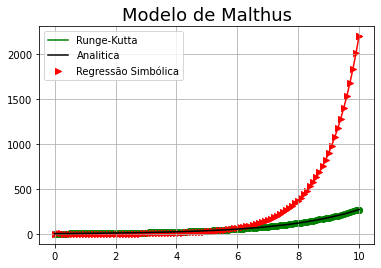

In [12]:
T0 = 0
TF = 10
H = 0.1
X0 = 5
K = 0.4

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

melhor_individuo = str(hof.items[0])
melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
func = toolbox.compile(expr=melhor_individuo_ever)
Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.scatter(T, X, c = 'g')
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r')
ax.plot(T, Xexpr, c = 'r')
ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('Malthus.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)

new_pset.addPrimitive(X0_add, 1)
new_pset.addPrimitive(X0_mul, 1)
new_pset.addPrimitive(X0_div, 1)
new_pset.addPrimitive(X0_sub, 1)
new_pset.addPrimitive(K_add, 1)
new_pset.addPrimitive(K_mul, 1)
new_pset.addPrimitive(K_div, 1)
new_pset.addPrimitive(k_sub, 1)

new_pset.addEphemeralConstant("rand102", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

k/t + exp(t)/t